In [1]:
# # mount on google drive
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
import os
os.chdir('..')
from notebooks import config
import os
import torch
import torch.nn as nn
import glob
import time
import random
import numpy as np
from utils.geotif_io import readTiff
from utils.imgShow import imgShow
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from utils.plot_dset_one import plot_dset_one


## 1.数据加载

### 获取数据集中标注数据的路径（原始影像、标注结果）

In [3]:
# ----------Data paths-------------- #
paths_truth = sorted(glob.glob(config.root+'/data/dataset-l578/truth/*'))
names_truth = [os.path.split(path_truth)[1] for path_truth in paths_truth]
names_scene = [filename.replace('_truth','') for filename in names_truth]
paths_scene = [config.root+'/data/dataset-l578/scene/'+n for n in names_scene]


### 在torch.utils.data.Dataset基类基础上，构建自己的数据加载类

In [4]:
## 将不规则图像随机裁剪为规则板块（如256x256）
class crop:
    '''randomly crop corresponding to specific patch size'''
    def __init__(self, size=(256,256)):
        self.size = size
    def __call__(self, image, truth):
        '''size: (height, width)'''
        start_h = random.randint(0, truth.shape[0]-self.size[0])
        start_w = random.randint(0, truth.shape[1]-self.size[1])
        patch = image[:,start_h:start_h+self.size[0],start_w:start_w+self.size[1]]
        truth = truth[start_h:start_h+self.size[0], start_w:start_w+self.size[1]]
        return patch, truth

### 自定义数据集读入
class Dataset(torch.utils.data.Dataset):
    def __init__(self, paths_scene, paths_truth):
        self.paths_scene = paths_scene
        self.paths_truth = paths_truth

    def __getitem__(self, idx):
        # load images ad masks
        scene_path = self.paths_scene[idx]
        truth_path = self.paths_truth[idx]
        scene,_ = readTiff(scene_path)
        truth,_ = readTiff(truth_path)
        ## Pre-processing
        scene = scene/10000  # normalization
        scene = scene.astype(np.float32).transpose((2, 0, 1))
        patch, truth = crop(size=(256,256))(scene, truth)
        truth = truth[np.newaxis,:].astype(np.float32)
        patch = torch.from_numpy(patch).float()
        truth = torch.from_numpy(truth).float()
        return patch, truth

    def __len__(self):
        return len(self.paths_scene)


In [5]:
tra_data = Dataset(paths_scene=paths_scene[7:], paths_truth=paths_truth[7:])
val_data = Dataset(paths_scene=paths_scene[0:7], paths_truth=paths_truth[0:7])


### 检查数据集：数据量，patch尺寸，还可以利用utils.imgShow中函数进行显示查看

torch.Size([6, 256, 256])
torch.Size([1, 256, 256])
training data size: 24
validation data size: 7


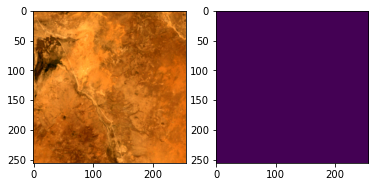

In [6]:
scene, truth = tra_data[0]
print(scene.shape)
print(truth.shape)
print('training data size:',len(tra_data))
print('validation data size:', len(val_data))
plt.subplot(1,2,1)
imgShow(scene.numpy().transpose((1, 2, 0)))
plt.subplot(1,2,2)
imgShow(truth[0].numpy())

In [7]:
### 利用torch.utils.data.DataLoader类定义数据加载

In [8]:
tra_loader = torch.utils.data.DataLoader(tra_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4)


### 检查dataloader

In [9]:
for x,y in tra_loader:
    print(y.shape)


torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])


## 2.模型构建，一种简单的u-net网络模型

In [10]:
""" Parts of the U-Net model """
def conv3x3_bn_relu(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class unet(nn.Module):
    def __init__(self, num_bands):
        super(unet, self).__init__()
        self.num_bands = num_bands
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.down_conv1 = conv3x3_bn_relu(num_bands, 16)
        self.down_conv2 = conv3x3_bn_relu(16, 32)
        self.down_conv3 = conv3x3_bn_relu(32, 64)
        self.down_conv4 = conv3x3_bn_relu(64, 128)
        self.up_conv1 = conv3x3_bn_relu(192, 64)
        self.up_conv2 = conv3x3_bn_relu(96, 48)
        self.up_conv3 = conv3x3_bn_relu(64, 32)
        self.outp = nn.Sequential(
                nn.Conv2d(32, 1, kernel_size=3, padding=1),
                nn.Sigmoid()) 

    def forward(self, x):  ## input size: 6x256x256
        ## encoder part
        x1 = self.down_conv1(x)              
        x1 = F.avg_pool2d(input=x1, kernel_size=2)  # 16x128x128
        x2 = self.down_conv2(x1)              
        x2 = F.avg_pool2d(input=x2, kernel_size=2) # 32x64x64
        x3 = self.down_conv3(x2)              
        x3 = F.avg_pool2d(input=x3, kernel_size=2) # 64x32x32
        x4 = self.down_conv4(x3)              
        x4 = F.avg_pool2d(input=x4, kernel_size=2) # 128x16x16
        ## decoder part
        x4_up = torch.cat([self.up(x4), x3], dim=1)  # (128+64)x32x32
        x3_up = self.up_conv1(x4_up)  # 64x32x32
        x3_up = torch.cat([self.up(x3_up), x2], dim=1)  # (64+32)x64x64
        x2_up = self.up_conv2(x3_up)  # 48x64x64
        x2_up = torch.cat([self.up(x2_up), x1], dim=1)  # (48+16)x128x128
        x1_up = self.up_conv3(x2_up)    # 32x128x128
        x1_up = self.up(x1_up)        # 32x256x256
        logits = self.outp(x1_up)
        return logits          


In [11]:
model = unet(num_bands=6)
summary(model, input_size=(6,256,256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             880
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
         Upsample-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 64,

## 3. 模型训练

In [12]:
# device = torch.device('cuda:0')   # 设置在gpu上运行
device = torch.device('cpu:0')
model = unet(num_bands=6).to(device) # 实例化模型
loss_bce = nn.BCELoss()      #  定义损失函数：二分类交叉墒损失
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 优化器：adam


In [13]:
## 精度评价指标：oa(overall accuracy), miou
def oa_binary(pred, truth):
    ''' des: calculate overall accuracy (2-class classification) for each batch
        input: 
            pred(4D tensor), and truth(4D tensor)
    '''
    # pred_bi = torch.where(pred>0.5, 1., 0.)    # [N,C,H,W]
    pred_bi = torch.where(pred>0.5,torch.ones(pred.shape),torch.zeros(pred.shape))
    inter = pred_bi+truth
    area_inter = torch.histc(inter.float().cpu(), bins=3, min=0, max=2)
    area_inter = area_inter[0:3:2]
    area_pred = torch.histc(pred.cpu(), bins=2, min=0, max=1)
    oa = area_inter/(area_pred+0.0000001)
    oa = oa.mean()
    return oa

def miou_binary(pred, truth):
    ''' des: calculate miou (2-class classification) for each batch
        input: 
            pred(4D tensor), and truth(4D tensor)
    '''
    # pred_bi = torch.where(pred>0.5, 1., 0.)   # [N,C,H,W]
    pred_bi = torch.where(pred>0.5,torch.ones(pred.shape),torch.zeros(pred.shape))
    inter = pred_bi+truth
    area_inter = torch.histc(inter.float().cpu(), bins=3, min=0, max=2)
    area_inter = area_inter[0:3:2]
    area_pred = torch.histc(pred.cpu(), bins=2, min=0, max=1)
    area_truth = torch.histc(truth.float().cpu(), bins=2, min=0, max=1)
    area_union = area_pred + area_truth - area_inter
    iou = area_inter/(area_union+0.0000001)
    miou = iou.mean()
    return miou


In [14]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model, loss_fn, optimizer, tra_loader, val_loader, epoches):
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                    optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        '''-----validation the model-----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                                    x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        format = 'Ep{}: tra-> Loss:{:.3f},Oa:{:.2f},Miou:{:.2f}, val-> Loss:{:.2f},Oa:{:.2f},Miou:{:.2f},time:{:.0f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))
        ## show the result
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, truth = val_data[sam_index]
            patch = torch.unsqueeze(patch, 0).to(device)
            truth = truth.to(device)
            pred = model(patch)
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            plt.figure(figsize=(10,4))
            plot_dset_one(inputs=[patch], truth=truth, pre=pred, binary_out=True, weights=None)


Ep1: tra-> Loss:0.523,Oa:0.71,Miou:0.61, val-> Loss:0.58,Oa:0.45,Miou:0.45,time:17s
Ep2: tra-> Loss:0.530,Oa:0.43,Miou:0.43, val-> Loss:0.55,Oa:0.37,Miou:0.37,time:16s
Ep3: tra-> Loss:0.527,Oa:0.38,Miou:0.38, val-> Loss:0.43,Oa:0.40,Miou:0.40,time:16s
Ep4: tra-> Loss:0.383,Oa:0.41,Miou:0.41, val-> Loss:0.32,Oa:0.43,Miou:0.43,time:16s
Ep5: tra-> Loss:0.365,Oa:0.62,Miou:0.53, val-> Loss:0.23,Oa:0.94,Miou:0.82,time:15s
Ep6: tra-> Loss:0.191,Oa:0.86,Miou:0.80, val-> Loss:0.33,Oa:0.89,Miou:0.72,time:15s
Ep7: tra-> Loss:0.151,Oa:0.91,Miou:0.80, val-> Loss:0.36,Oa:0.93,Miou:0.78,time:15s
Ep8: tra-> Loss:0.170,Oa:0.86,Miou:0.80, val-> Loss:0.29,Oa:0.92,Miou:0.78,time:15s
Ep9: tra-> Loss:0.197,Oa:0.88,Miou:0.74, val-> Loss:0.21,Oa:0.94,Miou:0.74,time:15s
Ep10: tra-> Loss:0.222,Oa:0.95,Miou:0.76, val-> Loss:0.20,Oa:0.95,Miou:0.67,time:15s


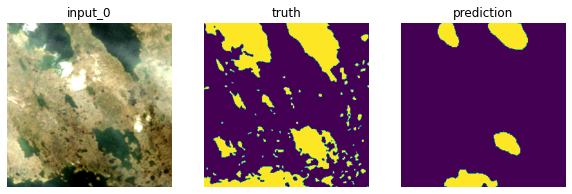

Ep11: tra-> Loss:0.169,Oa:0.94,Miou:0.80, val-> Loss:0.18,Oa:0.90,Miou:0.83,time:15s
Ep12: tra-> Loss:0.154,Oa:0.92,Miou:0.86, val-> Loss:0.15,Oa:0.95,Miou:0.85,time:14s
Ep13: tra-> Loss:0.132,Oa:0.91,Miou:0.78, val-> Loss:0.22,Oa:0.96,Miou:0.60,time:15s
Ep14: tra-> Loss:0.173,Oa:0.85,Miou:0.75, val-> Loss:0.20,Oa:0.97,Miou:0.72,time:15s
Ep15: tra-> Loss:0.163,Oa:0.92,Miou:0.75, val-> Loss:0.19,Oa:0.72,Miou:0.48,time:15s


In [15]:
train_loops(model=model, 
            loss_fn=loss_bce, 
            optimizer=optimizer,
            tra_loader=tra_loader, 
            val_loader=val_loader, 
            epoches=20)


In [1]:
## model saving
# path_save = config.root + '/model/pretrained/watnet_l578.pth'
# torch.save(model, path_save)
# model_1 = torch.load(path_save)
